# To-do
- Switching to numpy arrays broke everything-- get everything working again when back on internet
    - Use the edge density calculations used in prior versions of this notebook 
- Once that's finished, go through and see if I can switch the edge density and get interesting results that way

- Next steps:
    - Any ideas why my scale might be off? Consider reaching out to authors?
    - Comparing this with ER, networkx, showing how Newman-Ziff works?
    
Boost library for graphs: http://www.boost.org/doc/libs/1_65_1/libs/graph/doc/index.html

# Physics 514, Fall 2017: Studying explosive percolation on directed networks

Outline for report:
- Background
    - Phys 514 concepts: Percolation, critical point, critical exponents
    - Why is explosive percolation different?
    - Network theory background:
        - Networks: Directed v undirected, ordered v unordered, classical graphs (Erdos-Renyi)
        - Clustering: For directed networks, study the strongest connected component, SCC (define)
        - Clustering algorithms: Hoshen-Kopelman won't work here; Newman-Ziff for undirected networks, Tarjan's Algorithm (implemented here) for finding the SCC of directed networks

# Finding the strongest connected component using Tarjan's Algorithm

[notes to be cleaned up]

Paper reference: [https://doi.org/10.1137/0201010](https://doi.org/10.1137/0201010)

![here](https://upload.wikimedia.org/wikipedia/commons/6/60/Tarjan%27s_Algorithm_Animation.gif)

From Wikipedia:
- A depth-first search begins from an arbitrary start node
- subsequent depth-first searches are conducted on any nodes that have not yet been found
- As usual with depth-first search, the search visits every node of the graph exactly once, declining to revisit any node that has already been visited
- => the collection of search trees is a spanning forest of the graph

While going through the nodes:
- Nodes are placed on a stack in the order in which they are visited
- A node remains on the stack after it has been visited if and only if there exists a path in the input graph from it to some node earlier on the stack
- At the end of the call that visits v and its descendants, we know whether v itself has a path to any node earlier on the stack. 
    - If yes, the call returns, leaving v on the stack to preserve the invariant
    - If no, then v must be the root of its strongly connected component, which consists of v together with any nodes later on the stack than v (such nodes all have paths back to v but not to any earlier node, because if they had paths to earlier nodes then v would also have paths to earlier nodes which is false)

Book-keeping:
- Each node v is assigned:
    - a unique integer v.index, which numbers the nodes consecutively in the order in which they are discovered
    - a value v.lowlink that represents (roughly speaking) the smallest index of any node known to be reachable from v, including v itself
- Conditions:
    - if v.lowlink < v.index, leave v on stack
    - if v.lowlink == v.index, v must be removed as the root of a strongly connected component
- Calculating: The value v.lowlink is computed during the depth-first search from v, as this finds the nodes that are reachable from v.


# Implement search function for jumps from paper

This paper is particularly intreested in finding the explosive percolation phase transition.

While in our classic lattice percolation models, this was a matter of finding $p_c$, here it's going to be an edge density, $\delta=\frac{m}{n}$ where $m$ is the number of edges and $n$ is the number of nodes.

Instead of calculating the SCC every time an edge is added, it builds the completed graph then performs a binary search to find the edge addition at which the largest jump-- the percolation transition-- occured.

# Implementing the percolation processes 

The paper does an edge density of up to 50, with $10^6$ nodes.

The way the paper defines edge density is
$$\delta = \frac{m}{n}$$
where $m$ is the number of directed edges on the graph, and $n$ is the number of nodes. An edge density of 50 implies that each site has 50 neighbors, which is really dense. 

In [ ]:
# n = 10^4 and edge_density = 50 takes 4 min to run
n = 10**4
edge_density = 5e-5*n
m = int(edge_density*n)
ODER_test = g.Graph(n,m,'ODER')

In [ ]:
ODER_test.initialize()

In [ ]:
n = 10**4
edge_density = 5e-5*n
m = int(edge_density*n)
CODER_test = g.Graph(n,m,'CODER')

In [ ]:
CODER_test.initialize()

In [ ]:
print(CODER_test.n)
print(CODER_test.nodes)
print(CODER_test.m)
print(np.amax(CODER_test.edges))

In [ ]:
n = 10**2
p = 50/n
er = nx.erdos_renyi_graph(n,p,directed=True)

Visualizing networks of 100 nodes using a graph, especially at an edge density of 50, is likely to be a mess-- and not easy to do. The paper does not attempt to show graphs for their findings, beyond illustrative graphs of their processeds.

Instead, I steal the idea of how co-variance matrices are sometimes shown, and convert the edges of the graph to a binary yes/no edges array. This will show biases in my networks-- e.g. if there are no or fewer reverse edges, the lower traingle of the edge array will be sparser. This is indeed what we see for ODER and C-ODER, which have a preferential ordering rule. 

In [ ]:
er_viz = edges_to_viz(er.edges(),n)

plt.imshow(er_viz,cmap='binary')
plt.title('Erdos-Renyi stochastic graph for comparison')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()


# ODER_viz = edges_to_viz(ODER_test.edges,ODER_test.n)

plt.imshow(ODER_test.edges,cmap='binary')
plt.title('ODER simulation')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()


# CODER_viz = edges_to_viz(CODER_test.edges,CODER_test.n)

# plt.imshow(CODER_viz,cmap='binary')
# plt.title('CODER simulation')
# plt.ylabel('tail')
# plt.xlabel('head')
# plt.colorbar()
# plt.show()

# Replicating figures from the paper

I wonder if I also need to change the edge density, since I'm not using the same number of nodes.

Maybe the better metric is, what % of all other nodes is each node connected to, on average?

If $\delta=50$ for $n=10^6$, then each node is on average connected to $\frac{50}{10^6}=5e-5$ of the rest of the system.

So for a system of size $n$, we can set an equivalent density with $\frac{\delta}{n}=5e-5$.

Then the total number of edges in the system are $m={\delta}n$

In [ ]:
n = np.linspace(1000,10**6,10)
equiv_densities = n*(5*10**(-5))
m = equiv_densities*n
print(n)
print(equiv_densities)
print(m)

## Fig 5&6

I'm able to replicate the shape of these results, my "edge densities" are off by a factor of $\approx 5$. It's not clear to me why this is.

The equivalent density at these system sizes is much lower. If anything, I'm actually getting a much higher critical density than I should!

In [ ]:
def figure56(process,edge_densities,n):
    largest_scc = []
    Sample = g.Graph(n,0,process)
    for density in edge_densities:
        Sample.m = round(density*n)
        Sample.initialize()
#         largest_scc.append(ranked_SCC(tarjan(edges_to_children(Sample.edges)))/n)
#         largest_scc.append(ranked_SCC(tarjan(matrix_to_dict(Sample.edges)))/n)
        largest_scc.append(ranked_SCC(tarjan(Sample.edges))/n)
    return largest_scc

In [ ]:
# Plot ODER - might have to run outside of a jupyter notebook to get n-10^5 or higher

replicates = 1
n = 5*10**4
edge_density = 5e-5*n

# edge_densities = np.linspace(0.1*edge_density,edge_density,10)
# edge_densities = np.linspace(1,50,20)
edge_densities = np.linspace(10**(-6)*n,5*10**(-5)*n,2)
m = edge_densities*n
print(m)

for i in range(replicates):
    plt.plot(edge_densities,figure56('ODER',edge_densities,n))
plt.title('Explosive percolation of ODER process')
plt.ylabel('Largest SCC')
plt.xlabel('Edge density')
plt.show()

# ![fig5](figs/fig5.png)

In [ ]:
# Plot C-ODER

replicates = 10
edge_densities = np.linspace(1,10,20)
for i in range(replicates):
    plt.plot(edge_densities,figure56('CODER',edge_densities))
plt.title('Explosive percolation of C-ODER process')
plt.ylabel('Largest SCC')
plt.xlabel('Edge density')
plt.show()

![fig6](figs/fig6.png)

## Figure 7

Again, in the paper they simulate up to $10^6$ nodes, which is just wildly large.

![fig7](figs/fig7.png)

In [5]:
# Auto-reloads external files so I can stop re-loading
%load_ext autoreload
%autoreload 2

%matplotlib inline
from tools import *
import graphs as g

In [31]:
def figure7(process,n_sizes):
    edge_density = 5
    max_jump = []
    Sample = g.Graph(n_sizes[0],edge_density*n_sizes[0],process)
    for n in n_sizes:
        m = edge_density*n
        Sample.n = n
        Sample.m = m
        Sample.initialize()
        max_jump.append(get_largest_jump(Sample)/n)
    return max_jump

In [35]:
# Plotting ODER coefficient

# systems = np.linspace(500,1000,5).astype(int)
systems = [100]
replicates = 1

jumps = []
for i in range(replicates):
    jumps.append(figure7('ODER',systems))

ODER_jumps_array = np.asarray(jumps).reshape((replicates,len(jumps[0])))
ODER_avg_jump= np.mean(ODER_jumps_array, axis=0)
ODER_std_jump= np.std(ODER_jumps_array, axis=0)


0 250 499
250
249
0.0 0.0 0.0
1 1 1


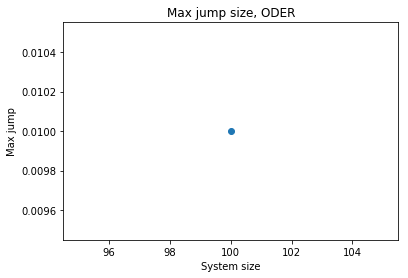

In [19]:
plt.errorbar(systems,ODER_avg_jump,yerr=ODER_std_jump, fmt='o')
# plt.axis([0,max(systems)*1.1,-0.05,0.20])
plt.title('Max jump size, ODER')
plt.ylabel('Max jump')
plt.xlabel('System size')
plt.show()

## Figure 8

Again, this spot-on replicates the finding that the C-ODER process jump comes from the combination of two large components combining-- but the critical edge density is off by a factor of 5! 

![fig8](figs/fig8.png)

In [ ]:
def figure8(process,edge_densities):
    n = 10**2
    first_scc,second_scc,third_scc = [],[],[]
    Sample = Graph(n,1,'CODER')
    for density in edge_densities:
        m = density*n
        Sample.m = m
        Sample.initialize()
        first_scc.append(ranked_SCC(tarjan(edges_to_children(Sample.edges)),rank=1)/n)
        second_scc.append(ranked_SCC(tarjan(edges_to_children(Sample.edges)),rank=2)/n)
        third_scc.append(ranked_SCC(tarjan(edges_to_children(Sample.edges)),rank=3)/n)
    return first_scc, second_scc, third_scc

In [ ]:
edge_densities = np.linspace(1,10,20)
first_scc, second_scc, third_scc = figure8('CODER',edge_densities)

plt.scatter(edge_densities,first_scc,label="Largest SCC")
plt.scatter(edge_densities,second_scc,label="Second largest SCC")
plt.scatter(edge_densities,third_scc,label="Third largest SCC")
plt.title('SCC combination near critical edge density in a C-ODER graph')
plt.ylabel('Component size')
plt.xlabel('Edge density')
plt.legend()
plt.show()

## Figure 9
Interesting, but low priority until other issues are worked out.

![fig9](figs/fig9.png)